# Hubble Deep Field (MUSE)

### Coordinates

### Source

## Setup

In [2]:
INPUT_FILE = "data/mosaic.fits"
OUTPUT_PATH = "outputs/muse_hubble_deep_field(mosaic)/"

In [4]:
# Imports
import os

# Scikit
import numpy as np
from astropy.convolution import convolve
# Astropy
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from photutils.aperture import CircularAperture
from photutils.segmentation import (SourceCatalog, deblend_sources,
                                    detect_sources, make_2dgaussian_kernel)

npa = np.array

import matplotlib.pyplot as plt
from matplotlib import cm

# Creates output folder
try:
    os.mkdir(OUTPUT_PATH)
except FileExistsError:
    pass

In [5]:
# Load FITS file
with fits.open(INPUT_FILE) as hdu_list:
    hdu_list.info()
    data = hdu_list[1].data
    print(data.shape)
    size = data.shape[0]
    wcs = WCS(hdu_list[1].header)
    print(wcs)

Filename: data/mosaic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     323   ()      
  1  DATA          1 ImageHDU        51   (945, 947, 3681)   float32   
  2  STAT          1 ImageHDU        51   (945, 947, 3681)   float32   


(3681, 947, 945)
WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'AWAV'  
CRVAL : 53.1631122222  -27.8244911111  4.75e-07  
CRPIX : 1.0  1.0  1.0  
CD1_1 CD1_2 CD1_3  : -4.1285823637633e-05  3.7173922575492e-05  0.0  
CD2_1 CD2_2 CD2_3  : 3.7173922575492e-05  4.1285823637633e-05  0.0  
CD3_1 CD3_2 CD3_3  : 0.0  0.0  1.25e-10  
NAXIS : 945  947  3681


In [6]:
# Helper Methods
def get_wavelength(i, imin, imax, vmin=720, vmax=380):
    return vmin + (vmax-vmin)*(i-imin)/(imax-imin)

def rgb2gray(rgb, fits=False):
    r, g, b = rgb[0], rgb[1], rgb[2]
    gray = (0.2989 * r + 0.5870 * g + 0.1140 * b)
    if fits:
        return gray
    return gray*np.ones(3)

def wavelength_to_rgb(wavelength, gamma=0.8):

    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    R *= 255
    G *= 255
    B *= 255
    return np.array([int(R), int(G), int(B)])

## Image Stacking

In [7]:
# Stores as 'picture_arr' and 'gray_arr'
N_LAYERS = 2

def intensity_matrix_to_rgb_matrix(layer, rgb):
    def filter_nans(cell):
        return rgb*cell if not np.isnan(cell) else np.zeros(3)
    return npa([[filter_nans(c) for c in row] for row in layer])

picture_arr = npa([[np.zeros(3)]*data.shape[2]]*data.shape[1])

for layer_i in range(0, size, size//N_LAYERS):
    color_vector = wavelength_to_rgb(get_wavelength(layer_i, 0, size))
    rgb_matrix = intensity_matrix_to_rgb_matrix(data[layer_i], color_vector)
    picture_arr += rgb_matrix/N_LAYERS
gray_arr = np.array([[rgb2gray(c) for c in row] for row in picture_arr])

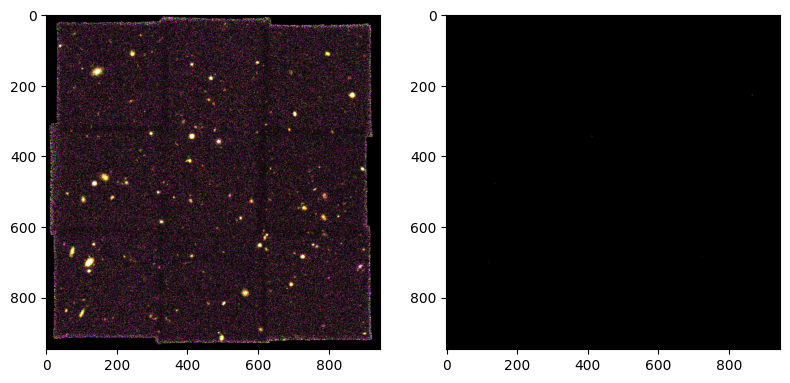

In [11]:
# Plot and save image
INTENSITY_FACTOR = 1/500

pic_adjusted = picture_arr*INTENSITY_FACTOR
gray_adjusted = gray_arr*INTENSITY_FACTOR
f, axarr = plt.subplots(1, 2, figsize=npa(picture_arr.shape[:2])/100)
axarr[0].imshow(np.clip(pic_adjusted, 0, 1))
axarr[1].imshow(np.clip(gray_adjusted*INTENSITY_FACTOR, 0, 1))
plt.imsave(f"{OUTPUT_PATH}stacked.png", np.clip(pic_adjusted, 0, 1))
plt.imsave(f"{OUTPUT_PATH}grayscale.png", np.clip(gray_adjusted, 0, 1))

In [8]:
# Save stacked image to .fits
gray_fits = np.array([[rgb2gray(c, True) for c in row] for row in picture_arr])
hdu = fits.PrimaryHDU(gray_fits)
hdu.writeto(f'{OUTPUT_PATH}.fits', overwrite=True)

# Source Identification

In [9]:
# Displays intensity in a given layer
LAYER_INDEX = 1500

#hdu = load_star_image()  
#test_data = hdu.data[0:401, 0:401]
# range(test_data.shape[0]), range(test_data.shape[1])

test_data = np.sqrt(data[LAYER_INDEX])
X, Y = np.meshgrid(range(test_data.shape[1]), range(test_data.shape[0]))

#fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
#surf = ax.plot_surface(X, Y, test_data, cmap=cm.coolwarm, rstride=1, cstride=1,
#    linewidth=0, antialiased=True, shade=False)

/tmp/ipykernel_13591/3963911965.py:8: RuntimeWarning: invalid value encountered in sqrt
  test_data = np.sqrt(data[LAYER_INDEX])


/mnt/c/Users/Mateus/Documents/development/caelestial-echoes/env/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:434: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(


'Success'

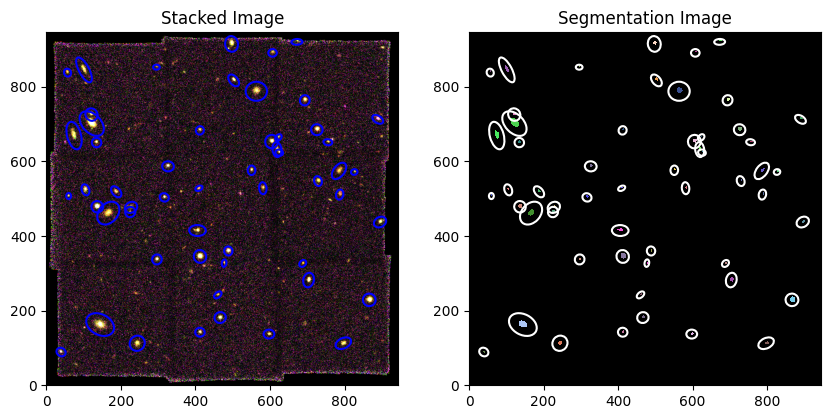

In [15]:
FWHM = 3
# Test source detection values
mean, median, std = sigma_clipped_stats(test_data, sigma=3.0)

# Segmentation
kernel = make_2dgaussian_kernel(FWHM, size=5)  # FWHM = 3.0
convolved_data = convolve(test_data, kernel, nan_treatment='fill', fill_value=0)
segment_map = detect_sources(convolved_data, 5*std, npixels=10)

segm_deblend = deblend_sources(convolved_data, segment_map,
    npixels=10, nlevels=32, contrast=0.001,
    progress_bar=False)

catalog = SourceCatalog(test_data, segm_deblend, convolved_data=convolved_data)
catalog_table = catalog.to_table().columns

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(np.clip(pic_adjusted, 0, 1), origin='lower', cmap='Greys_r')
ax1.set_title('Stacked Image')
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')

catalog.plot_kron_apertures(ax=ax1, color='blue', lw=1.5)
catalog.plot_kron_apertures(ax=ax2, color='white', lw=1.5)

"Success"